## Install the package dependencies before running this notebook

In [54]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
import random

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [67]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    
    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[:int(n * 0.95)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[:int(n * 0.95)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.95):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.95):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

In [68]:
# intialize a dataset
def get_data_loader(city = 'austin', batch_size = 20):
    train_dataset  = ArgoverseDataset(city = city, split = 'train')
    val_dataset = ArgoverseDataset(city = city, split = 'val')

    train_loader = DataLoader(train_dataset,batch_size=batch_size)
    val_loader = DataLoader(val_dataset,batch_size=batch_size)
    return train_dataset, val_dataset, train_loader, val_loader

In [69]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 20)

In [70]:
len(val_dataset)

2153

In [71]:
len(train_dataset)

40888

## models

In [114]:
from torch import nn, optim

# model1: EncoderDecoder
class EncoderDecoder(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.LogSigmoid(),
            nn.Linear(64, 32),
            nn.LogSigmoid(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.LogSigmoid(),
            nn.Linear(64, 120),
            nn.LogSigmoid(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x.float()

In [91]:
# model2: MLP
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(100, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 120)
        )
    
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.mlp(x)
        x = x.reshape(-1, 60, 2)
        return x.float()

In [83]:
# model, optimizer, loss
model_encdoc = EncoderDecoder()
opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [75]:
def train_epochs(model, train_loader, loss_func, opt, epochs = 10):
    train_losses = []
    for epoch in range(epochs):

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            inp, out = sample_batch
            out = out.float()
            preds = model(inp)
            loss = loss_func(preds, out) # MSE
            #loss = torch.sqrt(loss_func(preds, out)) # RMSE

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

        print('epoch {} trian loss: {}'.format(epoch, total_loss / len(train_dataset)))
        train_losses.append(total_loss / len(train_dataset))
    return train_losses

In [76]:
def val_loss(model, val_loader, loss_func, opt):
    val_loss = 0
    for i_batch, sample_batch in enumerate(val_loader):
        inp, out = sample_batch
        out = out.float()
        preds = model(inp)
        loss = loss_func(preds, out) # MSE
        #loss = torch.sqrt(loss_func(preds, out)) # RMSE

        val_loss += loss.item()
    print('val loss: {}'.format(val_loss / len(val_dataset)))

In [77]:
def train_city(city, batch_size, epochs, model):
    # data loader
    train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = city, batch_size = batch_size)
    
    # model, optimizer, loss
    model_encdoc = model
    opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
    loss_func = nn.MSELoss()
    
    # train
    train_losses = train_epochs(model_encdoc, train_loader, loss_func, opt, epochs = epochs)
    
    # evaluate
    # val_loss(model_encdoc, val_loader, loss_func, opt)
    return model_encdoc, train_losses

## Training

In [93]:
# model, optimizer, loss
mlp = MLP()
opt = optim.Adam(model_encdoc.parameters(), lr=1e-3)
loss_func = nn.MSELoss()

In [79]:
for i_batch, sample_batch in enumerate(train_loader):
    inp, out = sample_batch
    out = out.float()
    preds = mlp(inp)
    print(inp.shape)
    print(preds.shape)
    print(out.shape)
    loss = loss_func(preds, out)
    print(loss)
    break

torch.Size([20, 50, 2])
torch.Size([20, 60, 2])
torch.Size([20, 60, 2])
tensor(3108324.7500, grad_fn=<MseLossBackward0>)


epoch 0 trian loss: 18.656084424524337
epoch 1 trian loss: 8.285668845000368
epoch 2 trian loss: 7.988027494636167
epoch 3 trian loss: 8.32254065079037
epoch 4 trian loss: 12.108478139370908
epoch 5 trian loss: 6.219287333435285
epoch 6 trian loss: 9.247874609809687
epoch 7 trian loss: 6.519506212270696
epoch 8 trian loss: 8.94369125963307
epoch 9 trian loss: 10.906961446637814
val loss: 70.59846575250197


Text(0, 0.5, 'MSE')

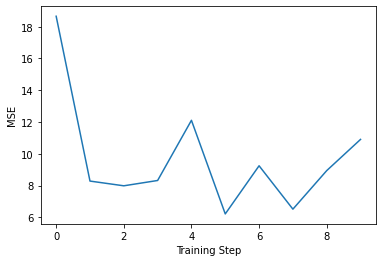

In [119]:
# austin
model = MLP()
model_austin, train_losses = train_city('austin', batch_size = 64, epochs = 10, model = model_austin)
val_loss(model_austin, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 2053.5413304812005
epoch 1 trian loss: 53.64883247156055
epoch 2 trian loss: 129.87901059103862
epoch 3 trian loss: 82.36375668323616
epoch 4 trian loss: 68.01532508612752
epoch 5 trian loss: 74.09488373011717
epoch 6 trian loss: 53.40699047968593
epoch 7 trian loss: 71.00274232175107
epoch 8 trian loss: 69.47282880627463
epoch 9 trian loss: 32.04107931126263
val loss: 486.3681930917615


Text(0, 0.5, 'MSE')

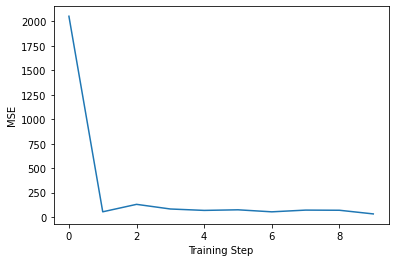

In [122]:
# miami
model = MLP()
model_miami, train_losses = train_city('miami', batch_size = 64, epochs = 10, model = model)
val_loss(model_miami, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 1506.0277791031651
epoch 1 trian loss: 22.190623282453267
epoch 2 trian loss: 29.47919206315117
epoch 3 trian loss: 29.98137062922123
epoch 4 trian loss: 29.877603529017865
epoch 5 trian loss: 31.87653624747882
epoch 6 trian loss: 25.28169364981445
epoch 7 trian loss: 27.055522172331134
epoch 8 trian loss: 23.78008643597965
epoch 9 trian loss: 22.077162139361164
val loss: 21357.81563516024


Text(0, 0.5, 'MSE')

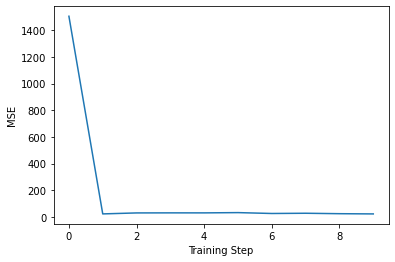

In [99]:
# pittsburgh
mlp = MLP()
model_pittsburgh, train_losses = train_city('pittsburgh', batch_size = 64, epochs = 10, model = mlp)
val_loss(model_pittsburgh, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 6127.583980601353
epoch 1 trian loss: 21.35731053748865
epoch 2 trian loss: 25.69160373951213
epoch 3 trian loss: 32.25526330000359
epoch 4 trian loss: 32.684072624002035
epoch 5 trian loss: 51.915927147310185
epoch 6 trian loss: 58.391755843157874
epoch 7 trian loss: 55.77607322219672
epoch 8 trian loss: 56.21581387580479
epoch 9 trian loss: 54.06083179131293
val loss: 48649.81832762424


Text(0, 0.5, 'MSE')

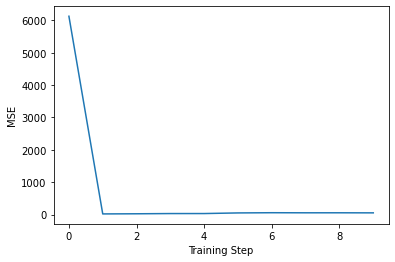

In [100]:
# dearborn
mlp = MLP()
model_dearborn, train_losses = train_city('dearborn', batch_size = 64, epochs = 10, model = mlp)
val_loss(model_dearborn, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 1795.107936109029
epoch 1 trian loss: 13.297185624282529
epoch 2 trian loss: 14.8218557305169
epoch 3 trian loss: 16.90432826881655
epoch 4 trian loss: 20.94930050886673
epoch 5 trian loss: 20.68043613601771
epoch 6 trian loss: 21.320269262783683
epoch 7 trian loss: 21.853007285801592
epoch 8 trian loss: 29.786378247330646
epoch 9 trian loss: 17.68941570946998
val loss: 21659.731624477474


Text(0, 0.5, 'MSE')

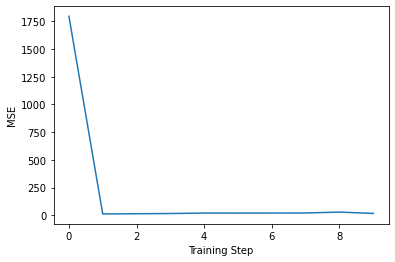

In [101]:
# washington_dc
mlp = MLP()
model_washington_dc, train_losses = train_city('washington-dc', batch_size = 64, epochs = 10, model = mlp)
val_loss(model_washington_dc, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

epoch 0 trian loss: 441.52832137682367
epoch 1 trian loss: 8.367219446316971
epoch 2 trian loss: 8.363886632230786
epoch 3 trian loss: 8.360479539584983
epoch 4 trian loss: 8.604956847631028
epoch 5 trian loss: 8.97338849125345
epoch 6 trian loss: 9.671518517249579
epoch 7 trian loss: 8.576246228383212
epoch 8 trian loss: 9.624766068224384
epoch 9 trian loss: 8.679318476740196
val loss: 153.00120012183217


Text(0, 0.5, 'MSE')

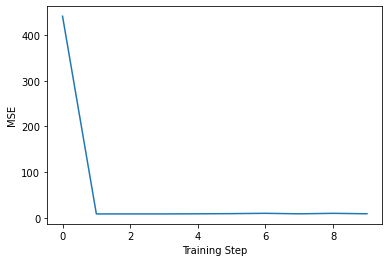

In [102]:
# palo_alto
mlp = MLP()
model_palo_alto, train_losses = train_city('palo-alto', batch_size = 64, epochs = 10, model = mlp)
val_loss(model_palo_alto, val_loader, loss_func, opt)
plt.plot(train_losses)
plt.xlabel('Training Step')
plt.ylabel('MSE')

## Make Prediction

In [103]:
cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
models = [model_austin, model_miami, model_pittsburgh, model_dearborn, model_washington_dc, model_palo_alto]

In [104]:
def predict_test(city, model):
    test_dataset = get_city_trajectories(city = city, split = 'test')[0]
    test_dataset = torch.from_numpy(test_dataset)
    pred = model(test_dataset).reshape(-1, 120)
    return pd.DataFrame(pred.detach().numpy())

In [105]:
columns =['ID'] + ['v'+str(i) for i in range(120)]

In [106]:
def predict_all(cities, models):
    out = predict_test(cities[0], models[0]).reset_index()
    out.columns = columns
    out['ID'] = out['ID'].astype(str) + '_' + cities[0]
    
    for city, model in zip(cities[1:], models[1:]):
        temp = predict_test(city, model).reset_index()
        temp.columns = columns
        temp['ID'] = temp['ID'].astype(str) + '_' + city
        out = pd.concat([out, temp])
    
    return out        

In [107]:
test_output = predict_all(cities, models)

In [108]:
test_output.to_csv('test_output.csv', index=False)

In [109]:
test_output

,ID,v0,v1,v2,v3,v4,v5,v6,v7,v8,...,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119
0,0_austin,69.085648,-629.160278,76.258377,-563.680786,87.988968,-552.345886,52.856350,-443.385132,44.978546,...,119.205254,-398.936127,125.793633,-519.026550,52.329597,-513.782043,76.967407,-591.699463,111.579712,-561.786133
1,1_austin,-251.472137,2.546588,-276.141327,-31.713495,-282.310364,-36.886852,-262.475433,24.536810,-285.295624,...,-267.657135,26.985666,-203.814606,28.532471,-280.044800,21.573021,-294.952332,19.869318,-286.462280,-3.841913
2,2_austin,78.691437,-268.151947,78.966698,-250.849716,86.075188,-240.839020,74.534592,-204.701340,70.090942,...,95.223717,-184.509842,101.249489,-230.785736,71.295097,-225.198212,85.460396,-253.429108,98.580582,-246.382950
3,3_austin,138.982193,1813.416382,51.898087,1521.123901,15.762643,1622.900146,230.726837,1538.589600,41.103802,...,37.563118,1709.648193,220.708282,1771.309082,89.288483,1799.593628,80.052818,1925.011475,52.987892,1766.839111
4,4_austin,1194.463257,-667.003845,1178.762085,-657.838379,1178.070190,-665.425659,1184.647339,-663.434021,1173.251343,...,1176.754028,-652.037842,1166.912476,-652.397827,1167.130981,-654.848999,1162.720215,-657.779053,1174.063232,-653.466003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1681,1681_palo-alto,-1338.544678,-501.175415,-1323.735718,-505.680573,-1313.554810,-504.681030,-1323.497803,-507.976624,-1326.206909,...,-1323.004028,-490.357758,-1321.727295,-492.872986,-1320.199585,-495.530304,-1323.165283,-507.110443,-1320.185303,-496.080322
1682,1682_palo-alto,126.552444,-28.388226,125.578110,-25.878479,126.486931,-27.268154,125.553574,-25.470182,125.891624,...,124.873177,-24.017971,125.261520,-25.358572,125.051788,-23.887232,121.834251,-25.420095,124.605766,-25.607801
1683,1683_palo-alto,-1176.131592,1968.313721,-1184.079468,1977.764038,-1189.784302,1966.822510,-1180.850952,1974.016602,-1211.623169,...,-1194.041138,1986.674072,-1205.423828,1984.660278,-1204.878784,1982.246216,-1188.630371,2000.565552,-1187.829834,2004.296509
1684,1684_palo-alto,1114.455933,1322.050781,1105.301514,1330.802734,1107.502563,1326.461792,1108.387695,1318.855225,1108.405273,...,1112.606323,1318.913330,1106.946533,1321.823242,1101.218994,1333.464111,1097.656982,1318.924561,1107.011475,1327.405762


## Sample a batch of data and visualize 

In [112]:
train_dataset, val_dataset, train_loader, val_loader = get_data_loader(city = 'austin', batch_size = 10)

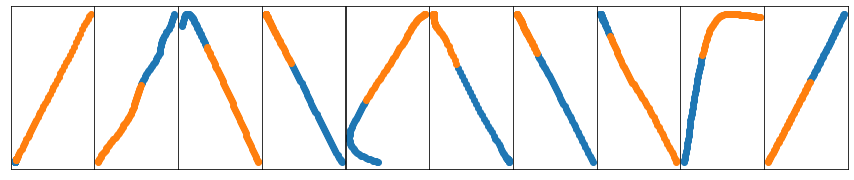

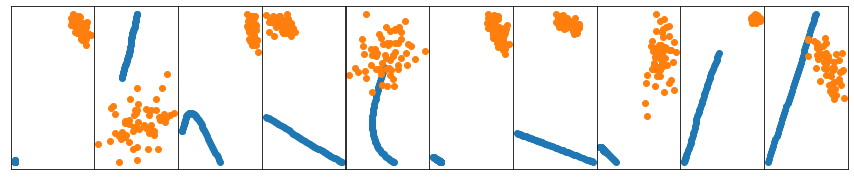

In [123]:
import matplotlib.pyplot as plt
import random


def show_sample_batch(sample_batch):
    """visualize the trajectory for a batch of samples"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i,:,0], inp[i,:,1])
        axs[i].scatter(out[i,:,0], out[i,:,1])

        
for i_batch, sample_batch in enumerate(train_loader):
    if i_batch < 5: continue
    inp, out = sample_batch
    pred = model_austin(inp).detach()
    show_sample_batch(sample_batch)
    show_sample_batch([inp, pred])
    #print(sample_batch)
    break